In [1]:
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
sys.path.append('../')
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Bella")

TypeError: 'type' object is not subscriptable

In [2]:
# set up the python objects for the geecs devices to be used in optimization
dev1 = GeecsDevice('ZTEST-ND-SimCam')

# define a dict containing the specific variables and bounds to be used in optimization
objs={'var1':{"GEECS_Object":dev1,'variable':"exposure","bounds":[0.001,0.08]}}


#define whether or not to use normalized values and ranges for optimization controls. 
#Normalization seems like a good idea
normalize=True

#for opt method, choose nelder or bayes for now
opt_method='bayes'

In [3]:
dev1.set('exposure',0.0015)

0.0015

In [4]:
value=dev1.get('exposure')
print(value,'sokdfhksd')

0.0015 sokdfhksd


In [5]:
#define the xopt configuration
YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name:
evaluator:
    function: __main__.geecs_measurement

vocs:
    variables:
        {}
    objectives: {f: "MAXIMIZE"}

"""

yaml_output = yaml.safe_load(YAML)

if opt_method == 'bayes':
    yaml_output['generator']['name'] = 'upper_confidence_bound'
    yaml_output['generator']['n_initial'] = 2
    yaml_output['generator']['acq'] = {'beta':0.1}
    yaml_output['xopt']['dump_file'] = 'bayes.yaml'
elif opt_method == 'nelder':
    yaml_output['generator']['name'] = 'neldermead'
    yaml_output['generator']['adaptive'] = True
    yaml_output['generator']['xatol'] = 0.01
    yaml_output['generator']['fatol'] = 0.005
    yaml_output['generator']['initial_point'] = { "var1": 0.006}
    yaml_output['xopt']['dump_file'] = 'nelder.yaml'

#define some functions to normalize/unnormalize real variables to [-1,1]
def unnormalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=(val/2+0.5)*range+offset
    return new_val

def normalize_var(obj,val):
    range=objs[obj]['bounds'][1]-objs[obj]['bounds'][0]
    offset=objs[obj]['bounds'][0]
    new_val=((val - offset)/range - 0.5)*2
    return new_val
    

for tag in objs.keys():
    yaml_output['vocs']['variables'][tag]=objs[tag]['bounds']
    
if normalize:
    for tag in objs.keys():
        yaml_output['vocs']['variables'][tag]=[-1.0,1.0]
    keys = yaml_output['vocs']['variables'].keys()
    

if yaml_output['generator']['name']=='neldermead':
    if normalize:
        initial_point = yaml_output['generator']['initial_point']

        normalized_initial_point = {}
        for key in keys:
            normalized_initial_point[key] = normalize_var(key, initial_point[key])

        yaml_output['generator']['initial_point'] = normalized_initial_point

print(yaml_output)

{'xopt': {'dump_file': 'bayes.yaml'}, 'generator': {'name': 'upper_confidence_bound', 'n_initial': 2, 'acq': {'beta': 0.1}}, 'evaluator': {'function': '__main__.geecs_measurement'}, 'vocs': {'variables': {'var1': [-1.0, 1.0]}, 'objectives': {'f': 'MAXIMIZE'}}}


In [6]:
dev1.set('exposure',0.15)

0.15

In [7]:
# #simulate transmission of blue diode through PMQ triplet
# import numpy as np

# optPosition = np.array([18.45, 0.6])
# numParts = 200000

# startDist = np.transpose([
#     np.random.normal(optPosition[0], 0.4, numParts),
#     np.random.normal(optPosition[1], 0.4, numParts)
# ])

# def calcTransmission(input_dict):
#     center1 = [input_dict['HexY'], input_dict['HexZ']]
#     separation = 15

#     center2 = [input_dict['HexY'], input_dict['HexZ']]
#     rotw = np.pi / 180 * (input_dict['HexW'] + 0.15) * 4
#     rotv = np.pi / 180 * (input_dict['HexV'] + 0.25) * 4

#     yOffset = separation * np.tan(rotw)
#     zOffset = separation * np.tan(rotv)

#     center2[0] = center2[0] + yOffset
#     center2[1] = center2[1] + zOffset

#     dist = startDist[
#         (np.sqrt((startDist[:, 0] - center1[0])**2 + (startDist[:, 1] - center1[1])**2) < 0.2) &
#         (np.sqrt((startDist[:, 0] - center2[0])**2 + (startDist[:, 1] - center2[1])**2) < 0.2)
#     ]

#     return len(dist) / numParts

In [8]:
ObjFunc=GeecsDevice('ZTEST-ND-SimCam')
ObjFunc.get("maxcounts")
def geecs_measurement(input_dict):
    for i in list(input_dict.keys()):
        set_val=float(input_dict[i])
        if normalize:
            set_val=unnormalize_var(i,set_val)
        
        print('set '+str(i)+' to '+str(set_val))
        
        # line below executes the set commands.
        objs[i]["GEECS_Object"].set(objs[i]["variable"],set_val)
        time.sleep(1)
        
    if normalize:
        setpoint = {}
        for key in input_dict:
            setpoint[key] = unnormalize_var(key, input_dict[key])
    else:
        setpoint=input_dict
        
    print(setpoint)
    
    outs=[]
    counter=0
    while counter<5:
        #val=simulate_objective(input_dict)
        val=ObjFunc.get("maxcounts")
        outs.append(val)
        counter=counter+1
        
    print(outs)

# this one is good for aligning to a crosshair
    return {'f': abs(np.median(outs))}


In [9]:
if opt_method == 'nelder':
    geecs_measurement(yaml_output['generator']['initial_point'])

In [10]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

X = Xopt(config=yaml_output)
X


            Xopt
________________________________
Version: 1.4.1
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: bayes.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  optim: {num_restarts: 20, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq: {proximal_lengthscales: null, use_transformed_proximal_weights: true, monte_carlo_samples: 128,
    beta: 0.1}
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 2
  use_cuda: false
evaluator:
  function: __main__.geecs_measurement
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    var1: [-1.0, 1.0]
  constraints: {}
  objectives: {f: MAXIMIZE}
  constants: {}
  linked_variables: {}


In [11]:
if opt_method == 'bayes':
    # print initial number of points to be generated
    print(X.generator.options.n_initial)

    # call X.step() to generate + evaluate initial points
    X.step()

    # inspect the gathered data
    X.data

import torch
import matplotlib.pyplot as plt
n_steps = 50

for i in range(n_steps):
    print('step'+str(i))
    X.step()


2
set var1 to 0.053293290096889386
{'var1': 0.053293290096889386}
[213.0, 213.0, 213.0, 213.0, 213.0]
set var1 to 0.04504927064345992
{'var1': 0.04504927064345992}
[180.0, 180.0, 180.0, 180.0, 180.0]
step0
set var1 to 0.06694330282598049
{'var1': 0.06694330282598049}
[268.0, 268.0, 268.0, 268.0, 268.0]
step1
set var1 to 0.08
{'var1': 0.08}
[320.0, 320.0, 320.0, 320.0, 320.0]
step2
set var1 to 0.08
{'var1': 0.08}
[320.0, 320.0, 320.0, 320.0, 320.0]
step3
set var1 to 0.08
{'var1': 0.08}
[320.0, 320.0, 320.0, 320.0, 320.0]
step4
set var1 to 0.08
{'var1': 0.08}
[320.0, 319.0, 320.0, 320.0, 320.0]
step5
set var1 to 0.08
{'var1': 0.08}
[320.0, 320.0, 320.0, 320.0, 320.0]
step6
set var1 to 0.08
{'var1': 0.08}


UnboundLocalError: cannot access local variable 'result' where it is not associated with a value

In [ ]:
X.data

{'var1': 0.08,
 'f': 320.0,
 'xopt_runtime': 5.156004799995571,
 'xopt_error': False}

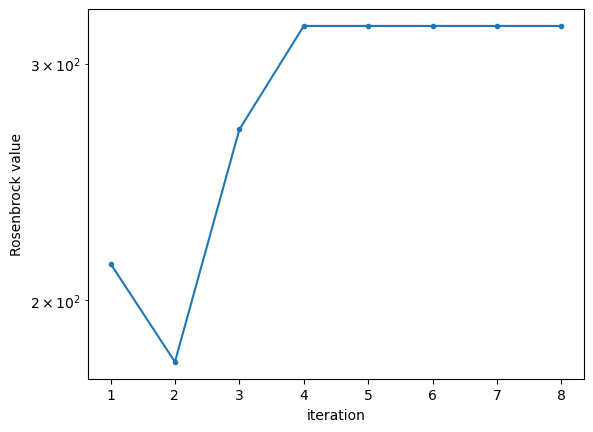

In [12]:
import matplotlib.pyplot as plt
X.data['f'].plot(marker='.')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Rosenbrock value')
best=dict(X.data.iloc[X.data["f"].argmax()]);

if normalize:
    for key in yaml_output['vocs']['variables'].keys():
        best[key] = unnormalize_var(key, best[key])

best